In [2]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

def calculate_metrics(true_values, pred_values):
    mse = round(mean_squared_error(true_values, pred_values),3)
    mae = round(mean_absolute_error(true_values, pred_values),3)
    r_score = round(r2_score(true_values, pred_values),3)

    return {"mse": mse,
            "mae": mae,
            "r^2": r_score,}

In [3]:
import h2o
from h2o.automl import H2OAutoML

# Start the H2O cluster (locally)
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 21.0.1+12-LTS-29, mixed mode, sharing)
  Starting server from C:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\38066\AppData\Local\Temp\tmp14r9kh9d
  JVM stdout: C:\Users\38066\AppData\Local\Temp\tmp14r9kh9d\h2o_38066_started_from_python.out
  JVM stderr: C:\Users\38066\AppData\Local\Temp\tmp14r9kh9d\h2o_38066_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Kiev
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.3
H2O_cluster_version_age:,1 month and 17 days
H2O_cluster_name:,H2O_from_python_38066_fo7ftz
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.952 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [13]:
import os
import sys
sys.path.insert(0, os.path.dirname('C:\work\DrugDiscovery\main_git\XAI_Chem\ml_part'))

import pandas as pd

from ml_part.random_forest.data_prep.preparation import DataPreparation
from ml_part.random_forest.train import RFTrain

CSV_PATH = r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\updated_features\remained_features_pKa_01.02_v2.csv'
smiles_filepath = r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\updated_features\smiles_to_index.pkl'

dataPreparation = DataPreparation(CSV_PATH)

unimportant_features_to_drop = []
X, y = dataPreparation.prepare_data_for_RF(is_pKa=True,
                                           use_mandatory_features=True,
                                           is_remove_outliers=True,
                                           is_remove_nan=True,
                                           outliers_features_to_skip=unimportant_features_to_drop)

correlated_features = ['f_atom_fraction', 'naHRing', 'nFaRing', 'nFaHRing', 'tpsa+f']
features_to_drop = []
for feature_name in X.columns:
    if feature_name in correlated_features:
        features_to_drop.append(feature_name)
    if len(X[feature_name].unique()) == 1:
        print(f"feature without unique values: {feature_name}")
        features_to_drop.append(feature_name)

X = X.drop(features_to_drop, axis=1)

rf_train = RFTrain(X=X, 
                   y=y,
                   smiles_filepath=smiles_filepath,
                   is_pKa=True,
                   k_folds=2)

y_train = rf_train.y_train
X_train = rf_train.X_train

y_test = rf_train.y_test
X_test = rf_train.X_test

train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

print(len(train_df), len(test_df))

train = h2o.H2OFrame(train_df)
test = h2o.H2OFrame(test_df)

True
183
['avg_atoms_in_cycle', 'nFaHRing', 'chirality', 'PPSA5', 'tpsa+f', 'RPCS', 'mol_num_cycles', 'GeomShapeIndex', 'angle_R2X2R1', 'nN', 'distance_between_atoms_in_f_group_centers', 'nC', 'nFARing', 'angle_R1X1R2', 'f_freedom', 'naHRing', 'nFAHRing', 'cis/trans', 'dipole_moment', 'f_to_fg', 'identificator', 'f_atom_fraction', 'nFRing', 'nFaRing', 'naRing', 'nFHRing', 'PBF', 'nARing', 'nF', 'dihedral_angle', 'nAHRing', 'nO', 'TASA', 'angle_X2X1R1', 'mol_volume', 'FPSA3', 'PNSA5', 'angle_X1X2R2', 'nHRing', 'pKa', 'logP']
distance_between_atoms_in_f_group_centers outliers indexes: [35]
dipole_moment outliers indexes: [82]
f_atom_fraction outliers indexes: [124]
PBF outliers indexes: [40, 71, 127]
mol_volume outliers indexes: [127]
FPSA3 outliers indexes: [40]
PNSA5 outliers indexes: [37, 38]
logP outliers indexes: [82, 83]
Remains rows:105, amount of features: 41
feature without unique values: nFaHRing
feature without unique values: naHRing
feature without unique values: nFaRing
feat

In [15]:
# train_df.to_csv(r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\updated_features\csv_for_rulefit\train_pKa_v3.csv')
# test_df.to_csv(r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\updated_features\csv_for_rulefit\test_pKa_v3.csv')

In [15]:
x = train.columns
y = "pKa"
x.remove(y)

aml = H2OAutoML(seed=1, max_runtime_secs_per_model=300)
aml.train(x=x, y=y, training_frame=train, fold_column="fold_id")

lb = aml.leaderboard
print(lb.head(rows=lb.nrows))

AutoML progress: |
23:14:02.827: Fold column fold_id will be used for cross-validation. nfolds parameter will be ignored.
23:14:02.828: AutoML: XGBoost is not available; skipping it.
23:14:02.949: _min_rows param, The dataset size is too small to split for min_rows=100.0: must have at least 200.0 (weighted) rows, but have only 92.0.

███████████████████████████████████████████████████████████████| (done) 100%
model_id                                                     rmse       mse       mae      rmsle    mean_residual_deviance
DeepLearning_grid_1_AutoML_2_20240206_231402_model_5     0.711117  0.505688  0.551501  0.0854436                  0.505688
DeepLearning_grid_1_AutoML_2_20240206_231402_model_26    0.712614  0.507819  0.550945  0.0859624                  0.507819
GBM_grid_1_AutoML_2_20240206_231402_model_240            0.715285  0.511633  0.550786  0.0864511                  0.511633
GBM_grid_1_AutoML_2_20240206_231402_model_681            0.721164  0.520077  0.547668  0.087414

In [18]:
best_prev_model = h2o.load_model(r'C:\work\DrugDiscovery\main_git\XAI_Chem\ml_part\h2o_model\models\25.01.24_features\pKa\Only_mol_with_angles_without_outliers(except_dipole)_with_angles(as features)\DeepLearning_grid_3_AutoML_1_20240126_235839_model_3')

top_features = []
for feature_index in range(15):
    top_features.append(best_prev_model.varimp()[feature_index][0])
top_features

unimportant_features_to_drop = []
for feature_name in X.columns:
    if feature_name not in top_features:
        unimportant_features_to_drop.append(feature_name)

unimportant_features_to_drop

['dipole_moment',
 'nHRing',
 'avg_atoms_in_cycle',
 'angle_R2X2R1',
 'nF',
 'nFRing',
 'f_freedom',
 'mol_num_cycles',
 'nFAHRing',
 'distance_between_atoms_in_f_group_centers',
 'nC',
 'nAHRing',
 'mol_volume',
 'nFaRing',
 'nFHRing',
 'angle_X2X1R1',
 'nFaHRing',
 'RPCS',
 'naRing',
 'nFARing',
 'naHRing',
 'chirality',
 'nARing']

In [16]:
best_model = aml.get_best_model()
best_model

Model Details
=============
H2ODeepLearningEstimator : Deep Learning
Model Key: DeepLearning_grid_1_AutoML_2_20240206_231402_model_5


Status of Neuron Layers: predicting pKa, regression, gaussian distribution, Quadratic loss, 3 501 weights/biases, 49,0 KB, 920 000 training samples, mini-batch size 1
    layer    units    type              dropout    l1    l2    mean_rate              rate_rms               momentum    mean_weight            weight_rms            mean_bias             bias_rms
--  -------  -------  ----------------  ---------  ----  ----  ---------------------  ---------------------  ----------  ---------------------  --------------------  --------------------  -----------------------
    1        33       Input             10.0
    2        100      RectifierDropout  40.0       0.0   0.0   0.09859573741725675    0.04925881326198578    0.0         -0.008355346455337536  0.3478816747665405    -0.7770128954128599   0.9919335842132568
    3        1        Linear                       0.0   0.0   0.0030870752385817467  0.0005149403586983681  0.0         0.006285274600086268   0.055275484919548035  0.031516996640192065  1.0971281125650402e-154

ModelMetricsRegression: deeplearning
** Reported on train data. **

MSE: 0.04239016821099506
RMSE: 0.2058887277414552
MAE: 0.16563955021352392
RMSLE: 0.03201851565506494
Mean Residual Deviance: 0.04239016821099506

ModelMetricsRegression: deeplearning
** Reported on cross-validation data. **

MSE: 0.5056877004306345
RMSE: 0.7111172198946067
MAE: 0.5515005290552025
RMSLE: 0.08544361534061133
Mean Residual Deviance: 0.5056877004306345

Cross-Validation Metrics Summary: 
                        mean       sd          cv_1_valid    cv_2_valid
----------------------  ---------  ----------  ------------  ------------
mae                     0.551501   0.0597398   0.509258      0.593743
mean_residual_deviance  0.505688   0.0242898   0.488512      0.522863
mse                     0.505688   0.0242898   0.488512      0.522863
r2                      0.895187   0.0123233   0.903901      0.886473
residual_deviance       0.505688   0.0242898   0.488512      0.522863
rmse                    0.711015   0.0170811   0.698936      0.723093
rmsle                   0.0851879  0.00934164  0.0785824     0.0917934

Scoring History: 
    timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_deviance    training_mae    training_r2
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  -------------------  --------------  -------------
    2024-02-06 23:15:13  0.000 sec                           0         0             0          nan              nan                  nan             nan
    2024-02-06 23:15:13  55.411 sec        115000 obs/sec    10        1             920        1.0349           1.07102              0.808038        0.779306
    2024-02-06 23:15:18  1 min  0.163 sec  193317 obs/sec    10000     1000          920000     0.205889         0.0423902            0.16564         0.991265

Variable Importances: 
variable                                   relative_importance    scaled_importance    percentage
-----------------------------------------  ---------------------  -------------------  --------------------
PPSA5                                      1.0                    1.0                  0.07556616852370938
nN                                         0.71549391746521       0.71549391746521     0.05406713394486507
nO                                         0.6825745701789856     0.6825745701789856   0.05157954500014372
PNSA5                                      0.6531543135643005     0.6531543135643005   0.04935636893078766
FPSA3                                      0.578251302242279      0.578251302242279    0.04369623535429447
angle_X1X2R2                               0.5586885213851929     0.5586885213851929   0.0422179509592555
angle_X2X1R1              

TRAIN

In [17]:
preds = best_model.predict(train)
true = train.as_data_frame()['pKa']
predicted_values = preds.as_data_frame()['predict']

calculate_metrics(true, predicted_values)

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


{'mse': 0.042, 'mae': 0.166, 'r^2': 0.991}

TEST

In [18]:
preds = best_model.predict(test)
true = test.as_data_frame()['pKa']
predicted_values = preds.as_data_frame()['predict']

calculate_metrics(true, predicted_values)

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


{'mse': 0.288, 'mae': 0.475, 'r^2': 0.945}

In [19]:
best_model = h2o.load_model(r'C:\work\DrugDiscovery\main_git\XAI_Chem\ml_part\h2o_model\models\01.02.24_features_2.1\pKa\all_molecules(without_angle_feature)_without_outliers\DeepLearning_grid_1_AutoML_3_20240201_153554_model_72')

preds = best_model.predict(test)
true = test.as_data_frame()['pKa']
predicted_values = preds.as_data_frame()['predict']

calculate_metrics(true, predicted_values)

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


{'mse': 0.11, 'mae': 0.285, 'r^2': 0.979}

PERMUTATION IMPORTANCE

c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
C:\Users\38066\AppData\Local\Temp\ipykernel_448\1178967373.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.barh(sum_rows.keys()[sorted_idx][::-1][:][::-1], sum_rows[sorted_idx][::-1][:][::-1])


Text(0.5, 0, 'H2O Feature Importance')

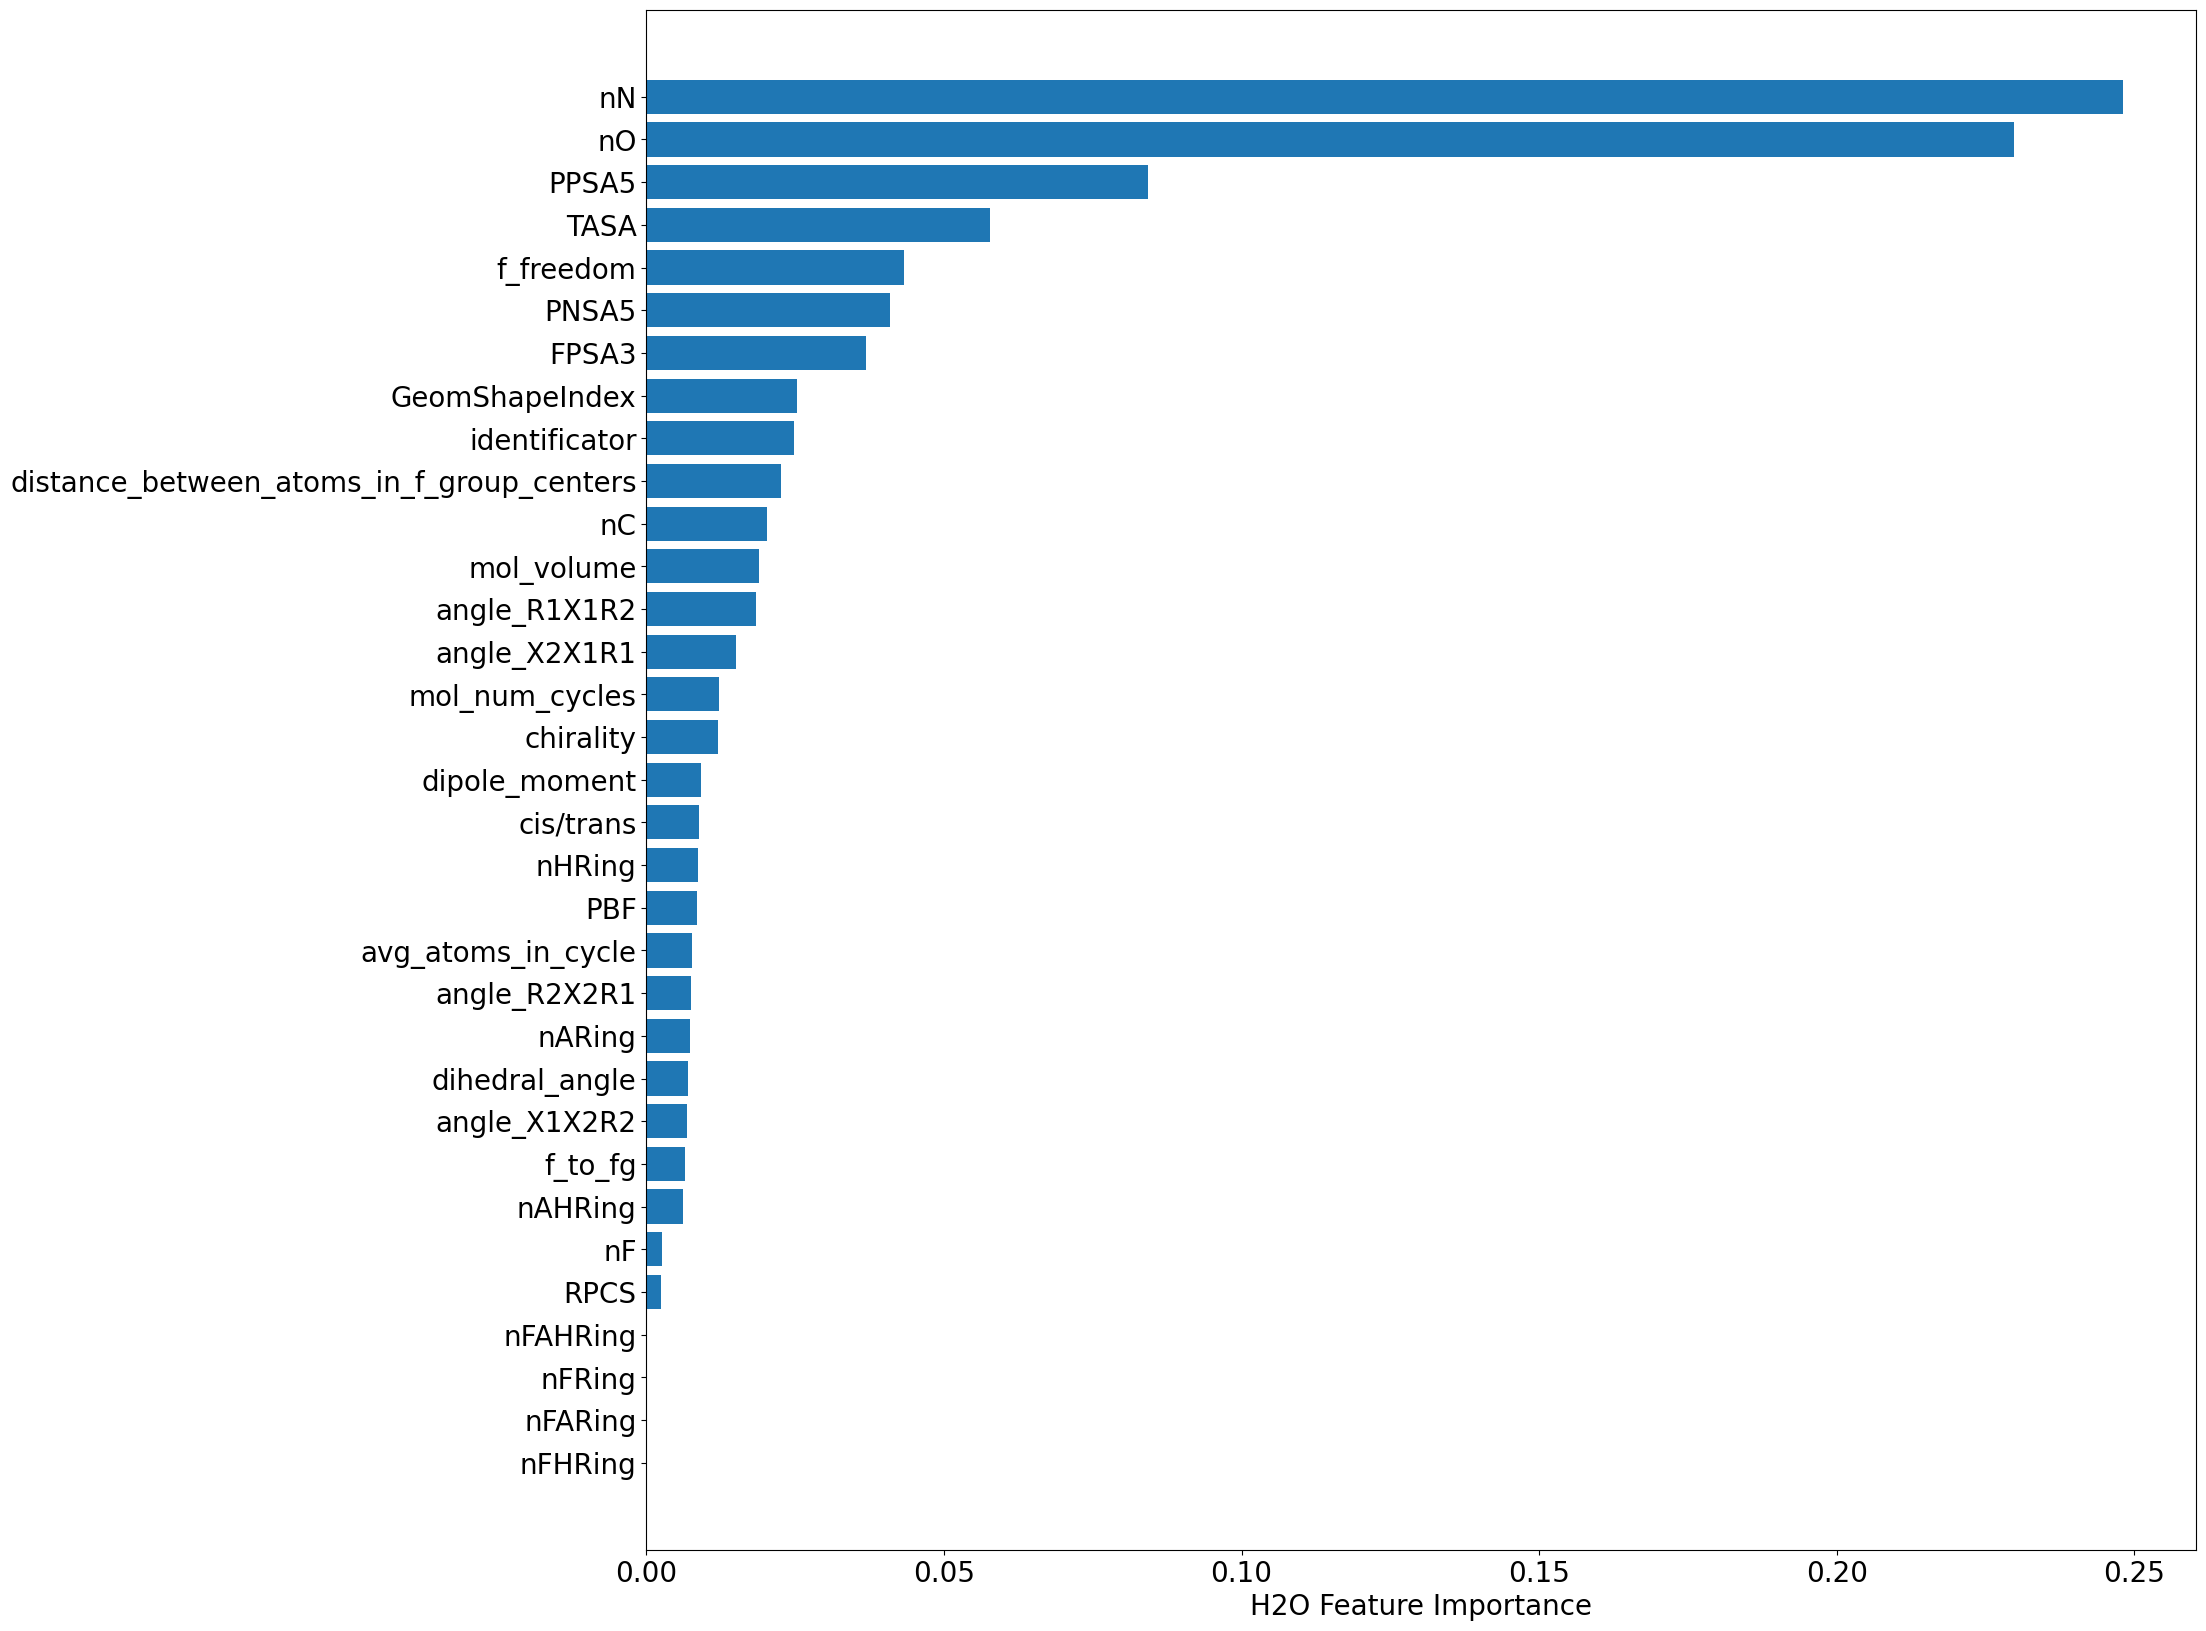

In [19]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})

permutation_varimp = best_model.permutation_importance(test, use_pandas=True, n_repeats=2000)

sum_rows = permutation_varimp.sum(axis=1)
sum_rows = sum_rows / sum(sum_rows)

sorted_idx = sum_rows.argsort()
plt.figure(figsize=(20,20))
plt.barh(sum_rows.keys()[sorted_idx][::-1][:][::-1], sum_rows[sorted_idx][::-1][:][::-1])
plt.xlabel("H2O Feature Importance")

SHAP

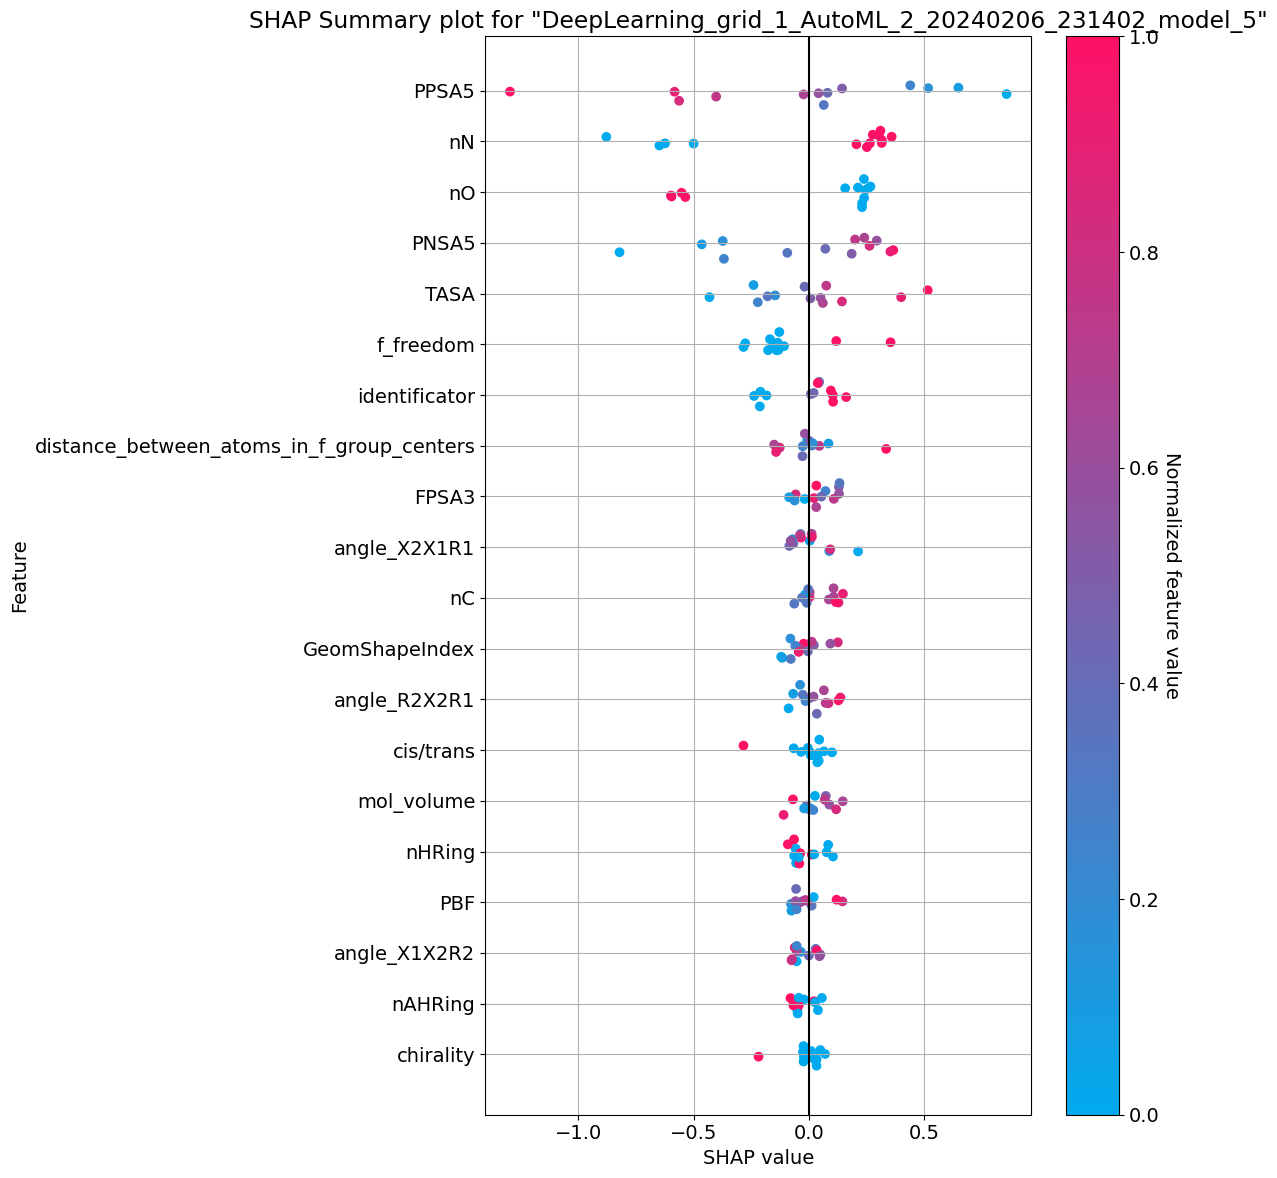

In [20]:
plt.rcParams.update({"font.size": 14})
shap_plot = best_model.shap_summary_plot(test, background_frame=train, samples=2000)

VAR IMPORTANCE

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Text(0.5, 0, 'Percent')

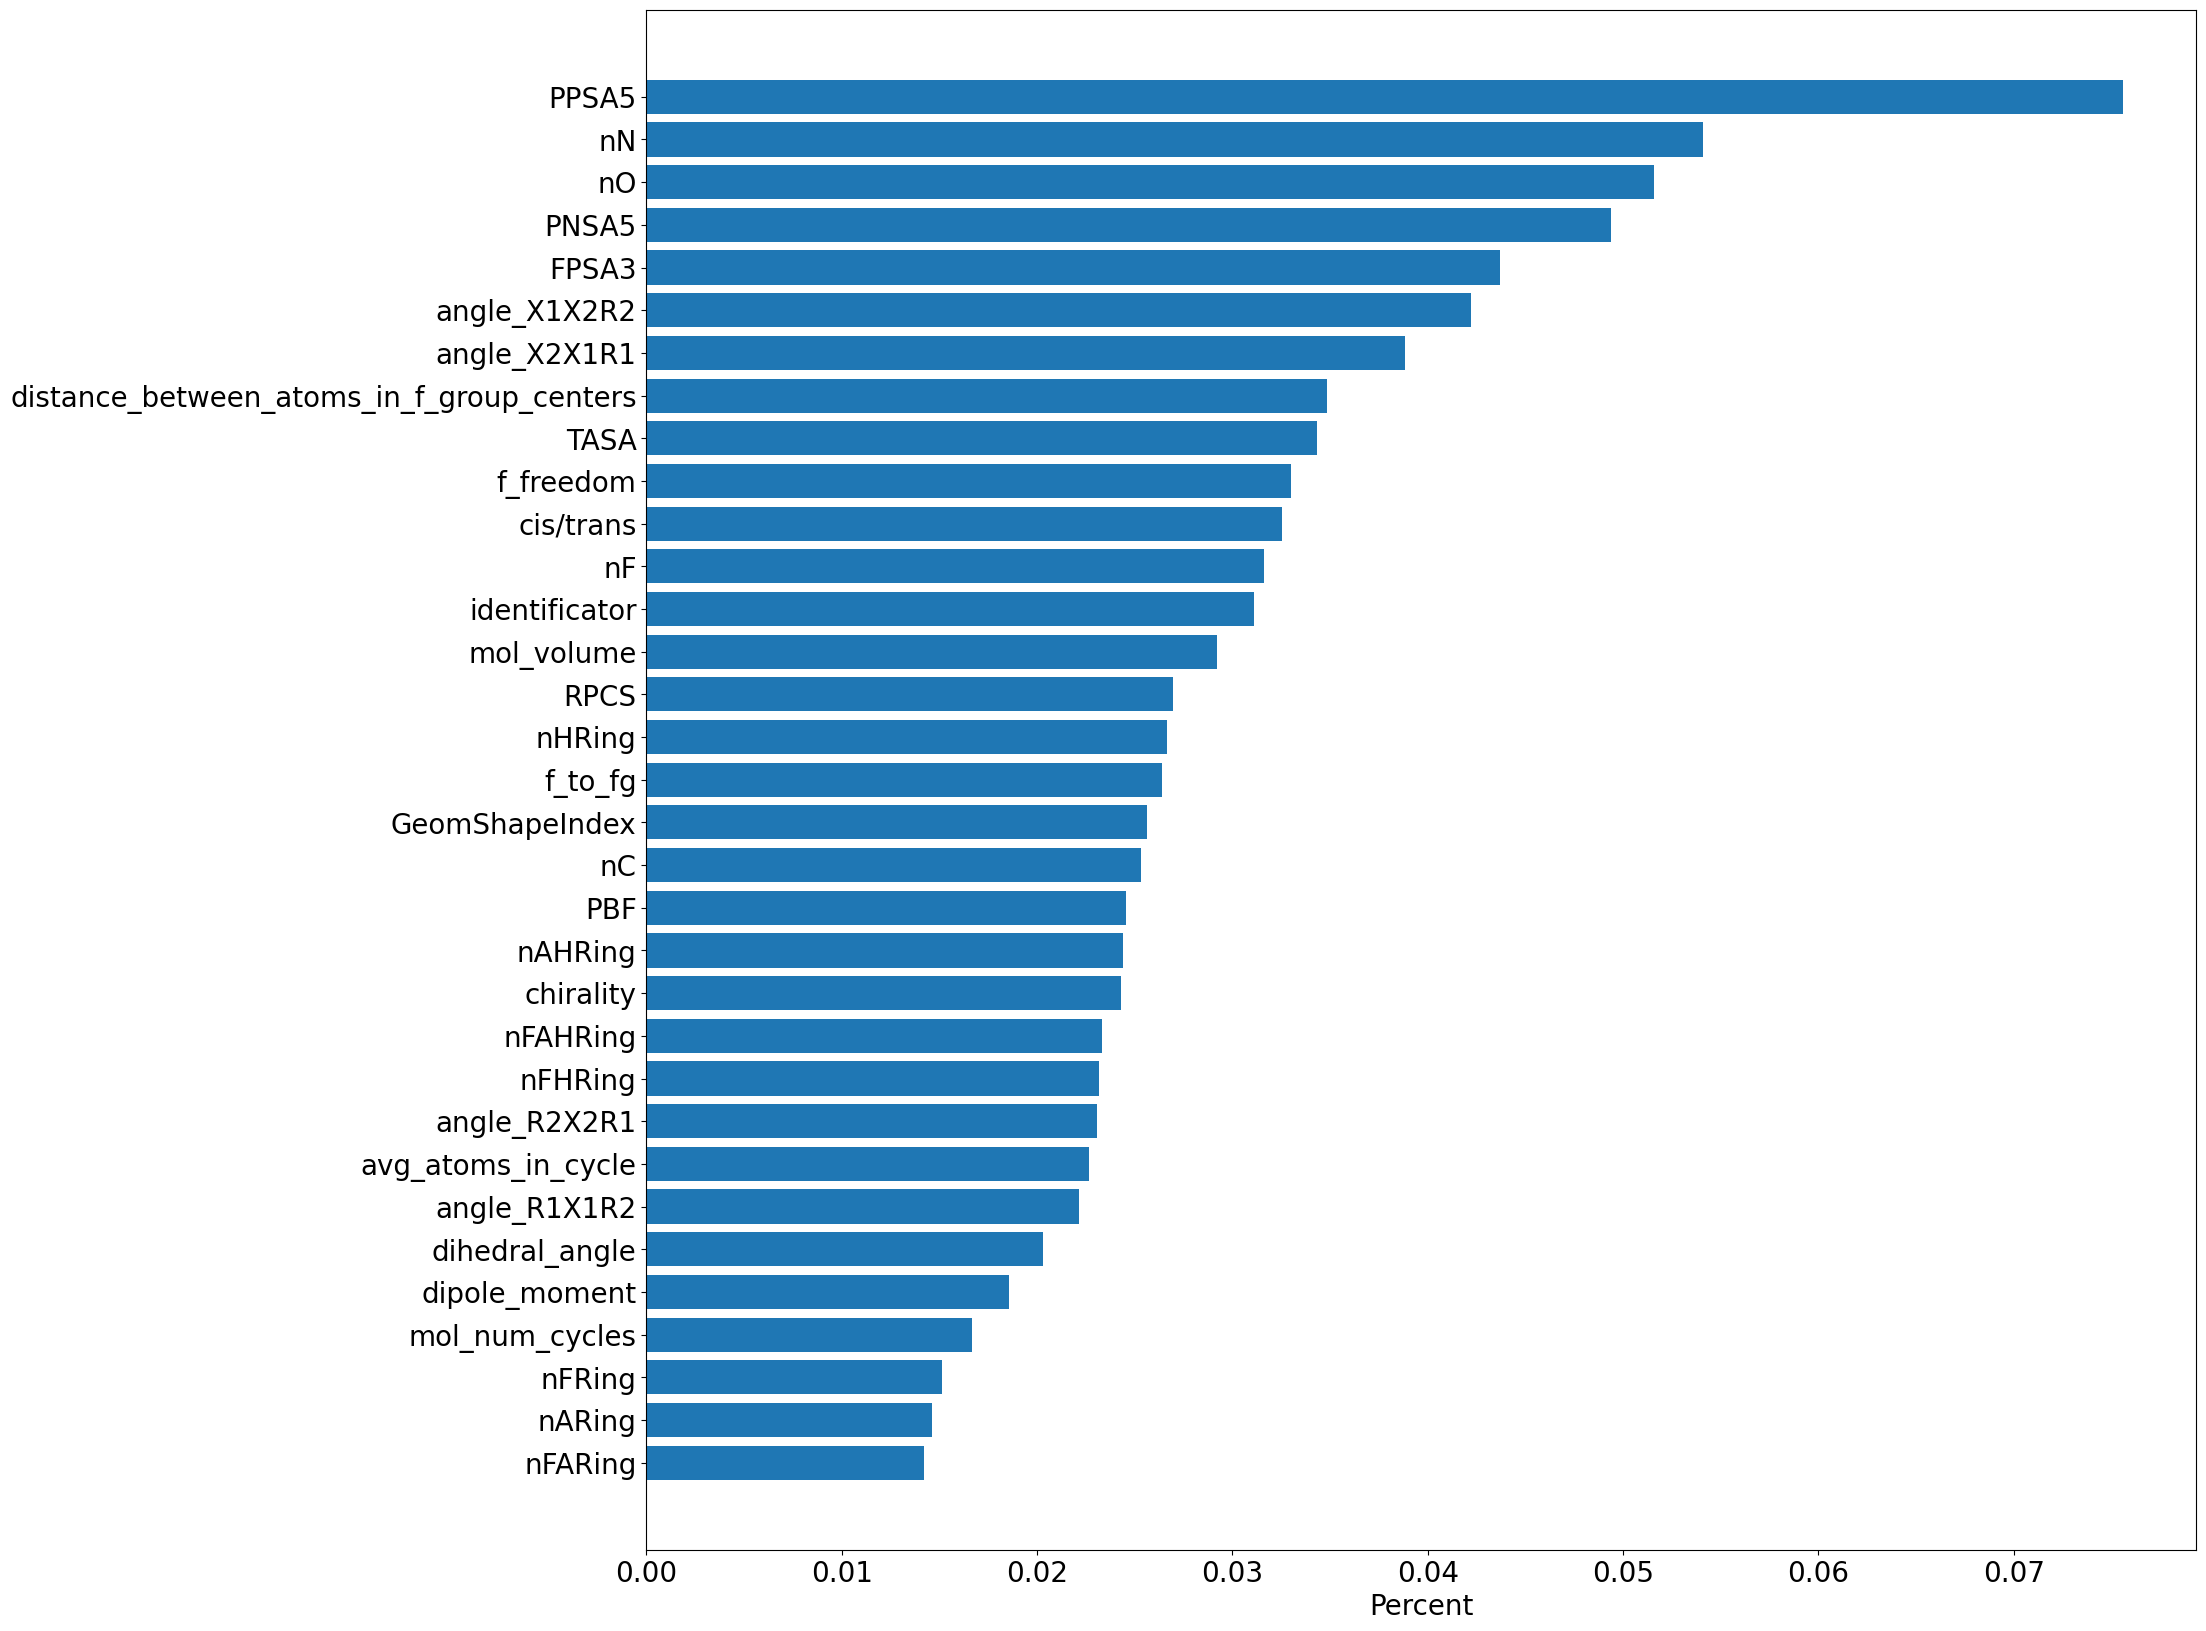

In [21]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})

preds = best_model.predict(test)
true = test.as_data_frame()['pKa']
predicted_values = preds.as_data_frame()['predict']

calculate_metrics(true, predicted_values)

importance = best_model.varimp(test)

fig, ax = plt.subplots(figsize=(20, 20))
ax.barh(importance['variable'][:][::-1], importance['percentage'][:][::-1])
ax.set_xlabel('Percent')


BEST MODEL SAVING

In [22]:
import os

MODEL_SAVE_PATH = r'C:\work\DrugDiscovery\main_git\XAI_Chem\ml_part\h2o_model\models\01.02.24_features_2.1\pKa'

best_model = aml.get_best_model()

model_path = h2o.save_model(model=best_model, path=os.path.join(MODEL_SAVE_PATH, 'only_with_angle_molecules(with_angle_feature)_without_outliers'), force=True)
model_path

'C:\\work\\DrugDiscovery\\main_git\\XAI_Chem\\ml_part\\h2o_model\\models\\01.02.24_features_2.1\\pKa\\only_with_angle_molecules(with_angle_feature)_without_outliers\\DeepLearning_grid_1_AutoML_2_20240206_231402_model_5'

In [19]:
best_model

Model Details
=============
H2ODeepLearningEstimator : Deep Learning
Model Key: DeepLearning_grid_1_AutoML_3_20240201_153554_model_72


Status of Neuron Layers: predicting pKa, regression, gaussian distribution, Quadratic loss, 601 weights/biases, 13,4 KB, 1 441 440 training samples, mini-batch size 1
    layer    units    type              dropout    l1    l2    mean_rate              rate_rms               momentum    mean_weight            weight_rms           mean_bias              bias_rms
--  -------  -------  ----------------  ---------  ----  ----  ---------------------  ---------------------  ----------  ---------------------  -------------------  ---------------------  -----------------------
    1        28       Input             0.0
    2        20       RectifierDropout  20.0       0.0   0.0   0.006155315171054099   0.003440672531723976   0.0         -0.003268691296865914  0.26069653034210205  -0.000600393816868855  0.3162055015563965
    3        1        Linear                       0.0   0.0   0.0010429051180835813  0.0007416477892547846  0.0         0.06576458439230919    0.21279138326644897  0.09533507739209846    1.0971281125650402e-154

ModelMetricsRegression: deeplearning
** Reported on train data. **

MSE: 0.0393238220197905
RMSE: 0.19830235001076132
MAE: 0.14851573936886517
RMSLE: 0.025423154285872447
Mean Residual Deviance: 0.0393238220197905

ModelMetricsRegression: deeplearning
** Reported on cross-validation data. **

MSE: 0.6970048631135096
RMSE: 0.834868171098593
MAE: 0.5892955130760777
RMSLE: 0.0967235632146753
Mean Residual Deviance: 0.6970048631135096

Cross-Validation Metrics Summary: 
                        mean       sd           cv_1_valid    cv_2_valid
----------------------  ---------  -----------  ------------  ------------
mae                     0.587028   0.0288639    0.566618      0.607438
mean_residual_deviance  0.696608   0.00505348   0.693034      0.700181
mse                     0.696608   0.00505348   0.693034      0.700181
r2                      0.892001   0.00925112   0.898542      0.885459
residual_deviance       0.696608   0.00505348   0.693034      0.700181
rmse                    0.834628   0.00302738   0.832487      0.836768
rmsle                   0.0966803  0.000540983  0.0962978     0.0970629

Scoring History: 
    timestamp            duration           training_speed    epochs    iterations    samples      training_rmse    training_deviance    training_mae    training_r2
--  -------------------  -----------------  ----------------  --------  ------------  -----------  ---------------  -------------------  --------------  -------------
    2024-02-01 15:49:15  0.000 sec                            0         0             0            nan              nan                  nan             nan
    2024-02-01 15:49:15  13 min  6.839 sec  288000 obs/sec    10        1             1440         1.37902          1.9017               1.09862         0.706942
    2024-02-01 15:49:18  13 min  9.755 sec  493812 obs/sec    10010     1001          1.44144e+06  0.198302         0.0393238            0.148516        0.99394

Variable Importances: 
variable                                   relative_importance    scaled_importance    percentage
-----------------------------------------  ---------------------  -------------------  --------------------
PPSA5                                      1.0                    1.0                  0.10724933045144022
FPSA3                                      0.6533231735229492     0.6533231735229492   0.0700684729287464
nF                                         0.45250624418258667    0.45250624418258667  0.04853099171367834
nN                                         0.4461650252342224     0.4461650252342224   0.047850900227220286
PNSA5                                      0.4190134108066559     0.4190134108066559   0.044938907759188115
nFRing                                     0.3792937994003296     0.3792937994003296   0.04067900603006823
ide

In [17]:
test_df

,avg_atoms_in_cycle,chirality,PPSA5,RPCS,mol_num_cycles,GeomShapeIndex,nN,distance_between_atoms_in_f_group_centers,nC,nFARing,...,nARing,nF,nAHRing,nO,TASA,mol_volume,FPSA3,PNSA5,nHRing,pKa
26,0.0,0,14.658366,16.590193,0,0.459796,0,0.000000,5,0,...,0,2,0,2,129.249891,118.34,0.044389,-34.120596,0,3.55
53,2.5,0,16.455047,27.417416,2,0.742680,0,0.933217,6,0,...,2,2,0,2,125.163042,119.14,0.045887,-33.215687,0,3.51
18,4.0,0,13.476809,21.306553,1,0.883250,0,1.155412,5,0,...,1,2,0,2,96.522239,109.54,0.046176,-43.762810,0,4.02
36,3.5,0,14.159698,22.806203,2,0.773356,0,1.520132,8,0,...,2,2,0,2,152.956231,148.75,0.040798,-29.008005,0,4.35
22,6.0,0,14.044210,24.924560,1,0.894953,0,1.645098,7,0,...,1,2,0,2,146.940376,139.52,0.043610,-30.254001,0,4.18
52,2.5,0,15.401796,18.180349,2,0.919507,0,0.000000,6,0,...,2,0,0,2,185.219675,108.96,0.048901,-16.082304,0,4.61
154,6.0,0,10.360490,0.000000,1,0.513970,1,4.464055,6,0,...,1,2,0,0,200.084128,122.46,0.033363,-16.320349,0,9.12
168,3.5,0,10.279217,1.869556,2,0.814447,1,6.444383,7,0,...,2,2,0,0,201.849049,132.63,0.029960,-16.347813,0,9.58
162,3.0,0,7.909767,84.836969,1,0.839966,1,0.000000,3,0,...,1,0,0,0,190.597796,67.22,0.040995,-7.196423,0,8.76
104,4.0,0,10.588537,107.940433,1,0.631338,1,0.000000,5,0,...,1,1,0,0,212.346295,103.30,0.041355,-10.255848,0,8.10
